In [1]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim

In this example we wanted to try out the second example from last time, which was:
$$ 
f(x) = \sum_{n=-\infty}^{\infty} c_n e^{i n x} \\
c_n = \frac{1}{2\pi} \int_{-\pi}^{\pi} f(x)\, e^{-i n x} \, dx
$$
We will use the generating functions from last time and use the PCA-Net architecture to learn the derivative of any $2\pi$-periodic, square-integrable function.

Copying the generating method for calculating any $2\pi$-periodic, square-integrable function and its derivative:

In [2]:
def generate_exponential_fourier_functions(num_funcs, sensor_points, K=5):
    """
    Generate periodic functions with their exact analytical derivative in exponential form
    f(x) = sum_{n=-K}^{K} c_n * exp(i n x)
    f'(x) = sum_{n=-K}^{K} (i n) * c_n * exp(i n x)
    """
    m = sensor_points.shape[0]
    sensor_points = sensor_points[None, :]  # shape (1, m)

    n_vals = torch.arange(-K, K+1).view(1, 2*K+1, 1)  # (1, 2K+1, 1) 
    x = sensor_points.view(1, 1, m)  # (1, 1, m)

    # Random complex coefficients
    a_n = torch.randn(num_funcs, 2*K+1, 1)
    b_n = torch.randn(num_funcs,2*K+1, 1)
    c_n = a_n + 1j * b_n  # shape (batch, 2K+1, 1)  # c_n = a_n + i*b_n

    # Compute exp(i n x)
    exp_inx = torch.exp(1j* n_vals* x)  # shape (1, 2K+1, m) #exp(inx)

    f_complex = (c_n *exp_inx).sum(dim=1) # shape (batch, m)
    f_deriv_complex = (1j * n_vals *c_n *exp_inx).sum(dim=1)

    # Take real part to ensure real-valued functions
    f = f_complex.real
    f_deriv = f_deriv_complex.real

    return f, f_deriv

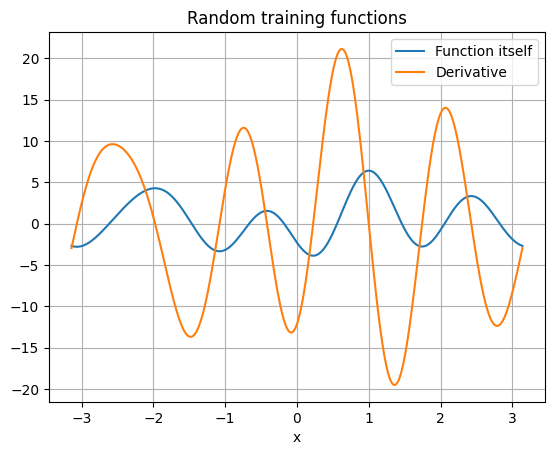

In [3]:
sensor_points_num = 500 #How many sensor points to consider
sensor_points = torch.linspace(-math.pi,math.pi,sensor_points_num) 

#Sanity check
f_sanity,f_deriv_sanity = generate_exponential_fourier_functions(1,sensor_points)

plt.plot(sensor_points,f_sanity.squeeze(),label="Function itself")
plt.plot(sensor_points,f_deriv_sanity.squeeze(),label="Derivative")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions")
plt.legend()

Generating training set with 500 samples:

In [4]:
f,f_deriv = generate_exponential_fourier_functions(500,sensor_points)
print(f.shape)
print(f_deriv.shape)

torch.Size([500, 500])
torch.Size([500, 500])


Calculating PCA components on Input:

In this section we were using: $C_N := \frac{1}{N} \sum_{j=1}^{N} u_j \otimes u_j$ to calculate the covariance matrix and the eigenvalues, eigenvectors and perform the PCA 'by hand'.

In [5]:
pca = PCA(n_components=10)
M_all = torch.zeros(500,500,dtype = torch.float32)
for i in range(sensor_points_num):
    M_all += torch.outer(f[i,:],f[i,:])

M_all /= sensor_points_num

In [6]:
C_numpy = M_all.numpy()
eigenvalues, eigenvectors = np.linalg.eigh(C_numpy)
idx = np.argsort(eigenvalues)[::-1]
eigenvectors_sort = eigenvectors[:, idx]
eigenvalues_sort = eigenvalues[idx]
print(eigenvalues_sort)
k=10
principalComponents = eigenvectors_sort[:, :k]  
print(np.linalg.norm(principalComponents[:,4]))

[ 6.49634399e+02  5.69809753e+02  5.62963013e+02  5.44526062e+02
  5.16891724e+02  4.57534485e+02  4.40428131e+02  4.27585938e+02
  4.17609406e+02  3.93764679e+02  3.79251892e+02  5.22508963e-05
  5.07591358e-05  4.89348604e-05  4.81088173e-05  4.79152659e-05
  4.71581152e-05  4.67690988e-05  4.59990188e-05  4.55682675e-05
  4.51763699e-05  4.43650351e-05  4.42743876e-05  4.37847157e-05
  4.32251218e-05  4.30169712e-05  4.24554964e-05  4.22668745e-05
  4.21514887e-05  4.19518838e-05  4.17125266e-05  4.14797614e-05
  4.07182415e-05  4.04521452e-05  4.01496836e-05  4.00158824e-05
  3.93305017e-05  3.90616042e-05  3.87177133e-05  3.86483844e-05
  3.84847408e-05  3.81708742e-05  3.79538869e-05  3.76603457e-05
  3.72622271e-05  3.71017486e-05  3.68079673e-05  3.67092653e-05
  3.64816769e-05  3.62128667e-05  3.59022270e-05  3.57347599e-05
  3.54907606e-05  3.51900671e-05  3.50254923e-05  3.46452798e-05
  3.45720946e-05  3.41970808e-05  3.40170227e-05  3.36384110e-05
  3.34782271e-05  3.33451

Plotting first 4 PCA components:

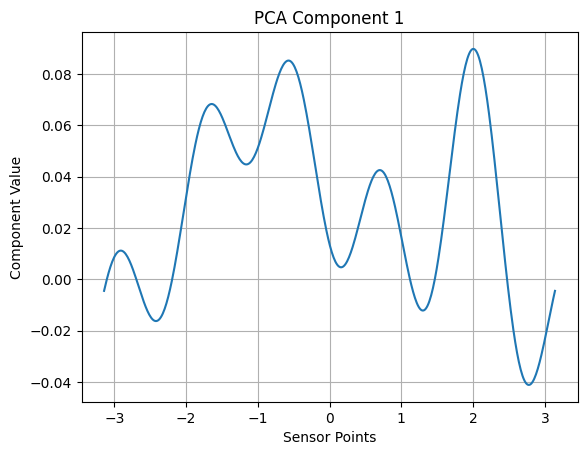

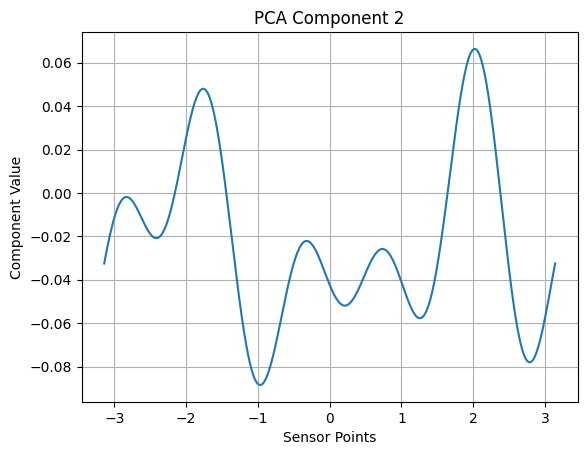

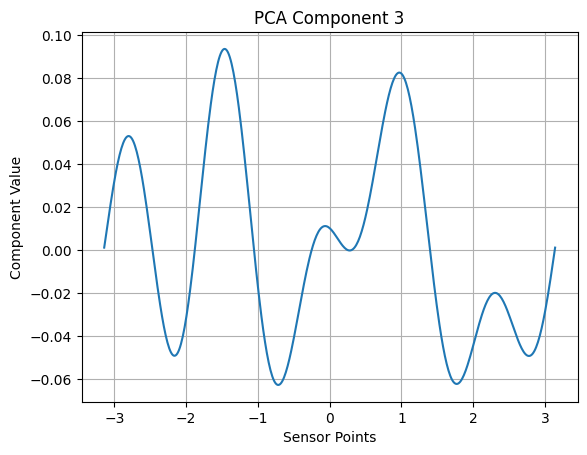

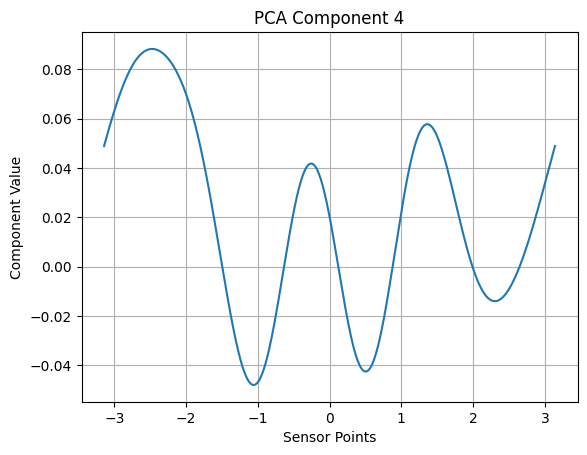

In [7]:
for i in range(4):
    plt.plot(sensor_points, principalComponents[:, i])
    plt.title(f'PCA Component {i+1}')
    plt.xlabel('Sensor Points')
    plt.ylabel('Component Value')
    plt.grid(True)
    plt.show()

Calculating PCA components on Output:

In [8]:
pca = PCA(n_components=10)
M_all_der = torch.zeros(500,500,dtype = torch.float32)
for i in range(sensor_points_num):
    M_all_der += torch.outer(f_deriv[i,:],f_deriv[i,:])

M_all_der /= sensor_points_num

In [9]:
C_numpy_der = M_all_der.numpy()
eigvals_der, eigvecs_der = np.linalg.eigh(C_numpy_der)
idx = np.argsort(eigvals_der)[::-1]
eigvecs_der_sort = eigvecs_der[:, idx]
eigvals_der_sort = eigvals_der[idx]
#print(eigvals_der_sort.shape)
print(eigvals_der_sort)
k=10
principalComponents_der = eigvecs_der_sort[:, :k]  # shape (num_points, k)
#print(principalComponents_der.shape)
print(np.linalg.norm(principalComponents_der[:,4]))

[ 1.35904551e+04  1.14887275e+04  7.51381494e+03  6.73989014e+03
  4.54347656e+03  4.32556787e+03  1.97447217e+03  1.83604602e+03
  4.87967438e+02  4.30420746e+02  6.43683423e-04  6.33597840e-04
  6.20597275e-04  6.17490557e-04  6.12105243e-04  6.02441083e-04
  5.97420498e-04  5.83404966e-04  5.79679850e-04  5.71737823e-04
  5.67129173e-04  5.64323331e-04  5.59158507e-04  5.56854473e-04
  5.52842044e-04  5.45718183e-04  5.42795053e-04  5.35469386e-04
  5.31707134e-04  5.30157064e-04  5.26462274e-04  5.23543975e-04
  5.19766530e-04  5.13714273e-04  5.07430348e-04  5.04814379e-04
  5.02640440e-04  4.94488282e-04  4.92911902e-04  4.87672107e-04
  4.86379460e-04  4.82161762e-04  4.80003306e-04  4.78295289e-04
  4.77134890e-04  4.73843305e-04  4.73327353e-04  4.65805497e-04
  4.62076772e-04  4.59780422e-04  4.58210037e-04  4.55420668e-04
  4.51706292e-04  4.48934035e-04  4.43093973e-04  4.40310629e-04
  4.36265575e-04  4.35926340e-04  4.31420194e-04  4.27004648e-04
  4.24949016e-04  4.22419

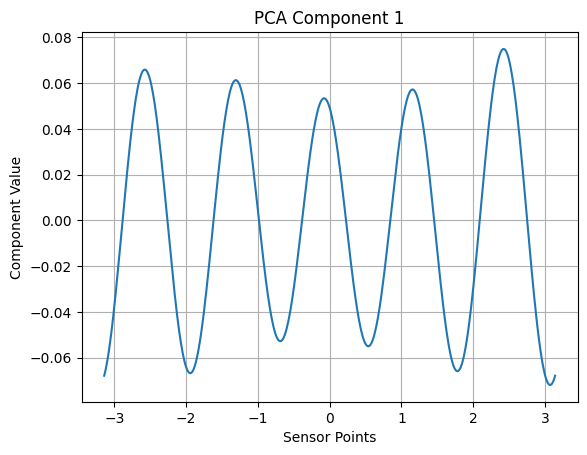

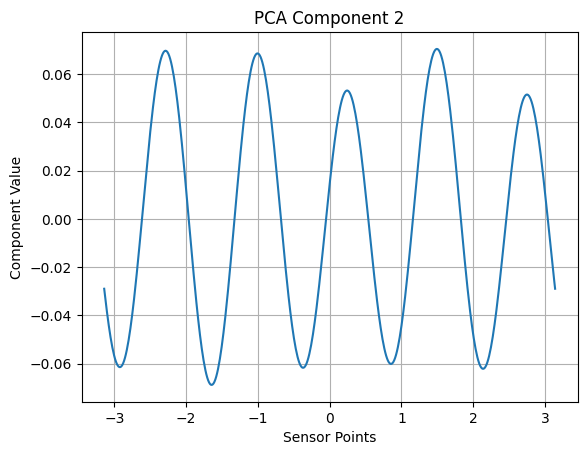

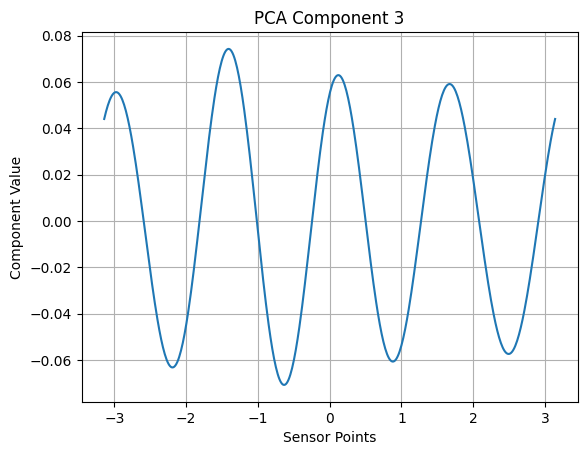

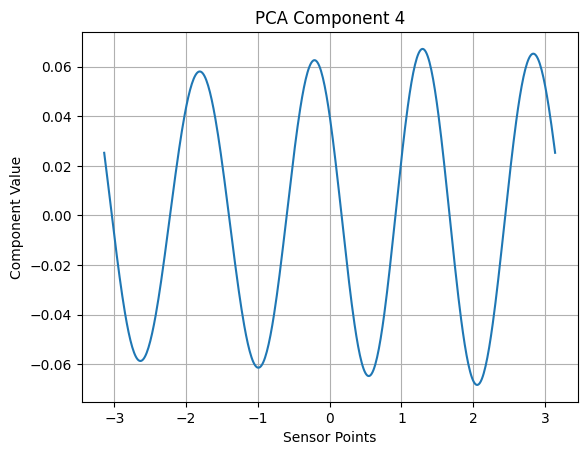

In [10]:
for i in range(4):
    plt.plot(sensor_points, principalComponents_der[:, i])
    plt.title(f'PCA Component {i+1}')
    plt.xlabel('Sensor Points')
    plt.ylabel('Component Value')
    plt.grid(True)
    plt.show()

Projecting Input with PCA components:

In [12]:
principalComponents_t2 = torch.from_numpy(principalComponents)
principalComponents_t2 = principalComponents_t2.to(dtype = torch.float32)
print(principalComponents_t2.dtype)
print(f.dtype)
f_encoded = f @ principalComponents_t2

print(f_encoded.shape)

torch.float32
torch.float32
torch.Size([500, 10])


Projecting Output with PCA components:

In [14]:
principalComponents_t_der2 = torch.from_numpy(principalComponents_der)
principalComponents_t_der2 = principalComponents_t_der2.to(dtype = torch.float32)
print(principalComponents_t_der2.dtype)
print(f.dtype)
f_encoded_der = f_deriv @ principalComponents_t_der2

print(f_encoded_der.shape)

torch.float32
torch.float32
torch.Size([500, 10])


Defining the Neural Network:

In [15]:
class FiveLayerSELU(nn.Module):
    def __init__(self):
        super(FiveLayerSELU, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 20),
            nn.SELU(),
            nn.Linear(20, 30),
            nn.SELU(),
            nn.Linear(30, 100),
            nn.SELU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        return self.net(x)

Defining training of neural network:

In [16]:
# Modell, Loss, Optimizer
model = FiveLayerSELU()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_all = []
for epoch in range(10000):
    outputs = model(f_encoded)
    loss = criterion(outputs, f_encoded_der)
    loss_all.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 5313.8008
Epoch 2, Loss: 5301.6748
Epoch 3, Loss: 5289.7012
Epoch 4, Loss: 5277.8496
Epoch 5, Loss: 5266.0806
Epoch 6, Loss: 5254.3545
Epoch 7, Loss: 5242.6519
Epoch 8, Loss: 5230.9526
Epoch 9, Loss: 5219.2104
Epoch 10, Loss: 5207.3784
Epoch 11, Loss: 5195.4546
Epoch 12, Loss: 5183.3906
Epoch 13, Loss: 5171.1655
Epoch 14, Loss: 5158.7310
Epoch 15, Loss: 5146.0518
Epoch 16, Loss: 5133.0850
Epoch 17, Loss: 5119.7959
Epoch 18, Loss: 5106.1436
Epoch 19, Loss: 5092.0898
Epoch 20, Loss: 5077.5933
Epoch 21, Loss: 5062.6157
Epoch 22, Loss: 5047.1265
Epoch 23, Loss: 5031.0923
Epoch 24, Loss: 5014.4658
Epoch 25, Loss: 4997.2031
Epoch 26, Loss: 4979.2656
Epoch 27, Loss: 4960.6226
Epoch 28, Loss: 4941.2310
Epoch 29, Loss: 4921.0479
Epoch 30, Loss: 4900.0283
Epoch 31, Loss: 4878.1313
Epoch 32, Loss: 4855.3340
Epoch 33, Loss: 4831.5918
Epoch 34, Loss: 4806.8696
Epoch 35, Loss: 4781.1182
Epoch 36, Loss: 4754.2988
Epoch 37, Loss: 4726.3750
Epoch 38, Loss: 4697.3242
Epoch 39, Loss: 4667.

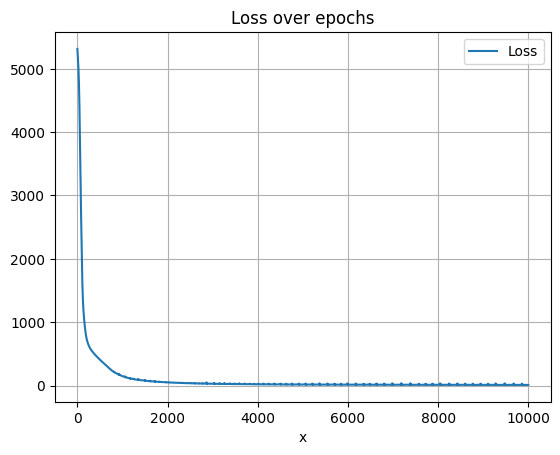

In [17]:
plt.plot(range(10000),loss_all,label="Loss")
plt.grid()
plt.xlabel("x")
plt.title("Loss over epochs")
plt.legend()
#print(f.squeeze())

Using output PCA-components to get back in original Output space:

In [18]:
outputs = model.forward(f_encoded)
print(outputs.shape)
f_der_decoded = outputs @ principalComponents_t_der2.T
print(f_der_decoded.shape)

torch.Size([500, 10])
torch.Size([500, 500])


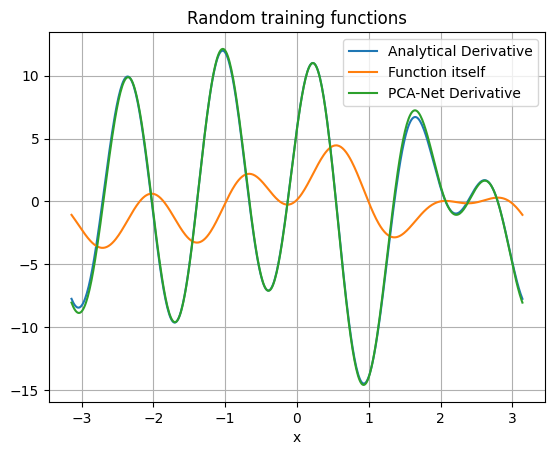

In [19]:
plt.plot(sensor_points,f_deriv[3,:].squeeze(),label="Analytical Derivative") #squeeze removes all dimensions from size 1
plt.plot(sensor_points,f[3,:].squeeze(),label="Function itself")
plt.plot(sensor_points,f_der_decoded[3,:].detach().numpy().squeeze(),label="PCA-Net Derivative")
#plt.plot(sensor_points,f_der.squeeze(),label="Derivative")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions")
plt.legend()


Performing PCA-Net on a test function:

In [20]:
testfun, testder = generate_exponential_fourier_functions(1,sensor_points)
test_coeffs = testfun @ principalComponents_t2
test_coeffs_der = model.forward(test_coeffs)
test_out = principalComponents_t_der2 @ test_coeffs_der.T

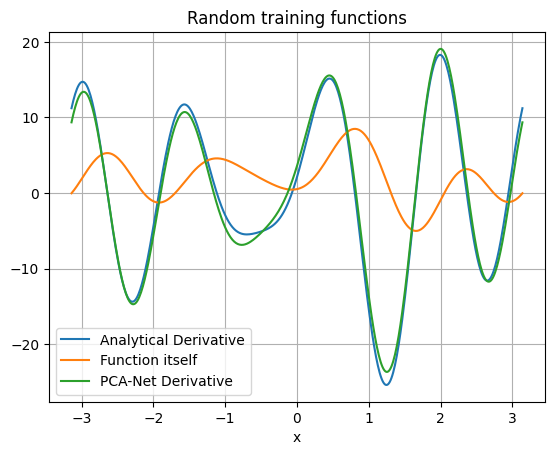

In [21]:
plt.plot(sensor_points,testder.squeeze(),label="Analytical Derivative") #squeeze removes all dimensions from size 1
plt.plot(sensor_points,testfun.squeeze(),label="Function itself")
plt.plot(sensor_points,test_out.detach().numpy().squeeze(),label="PCA-Net Derivative")
#plt.plot(sensor_points,f_der.squeeze(),label="Derivative")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions")
plt.legend()


Using the optimizer from the paper:

In [23]:
# Modell, Loss, Optimizer
model2 = FiveLayerSELU()
optimizer = optim.SGD(model2.parameters(), lr=0.0001, momentum=0.99)
loss_all = []
for epoch in range(10000):
    outputs = model2(f_encoded)
    loss = criterion(outputs, f_encoded_der)
    loss_all.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 5300.7446
Epoch 2, Loss: 5295.6406
Epoch 3, Loss: 5285.5420
Epoch 4, Loss: 5270.5913
Epoch 5, Loss: 5250.8804
Epoch 6, Loss: 5226.3608
Epoch 7, Loss: 5196.7310
Epoch 8, Loss: 5161.2344
Epoch 9, Loss: 5118.4590
Epoch 10, Loss: 5066.1460
Epoch 11, Loss: 5000.6279
Epoch 12, Loss: 4916.3267
Epoch 13, Loss: 4804.9438
Epoch 14, Loss: 4654.7974
Epoch 15, Loss: 4449.9277
Epoch 16, Loss: 4173.5137
Epoch 17, Loss: 3826.7576
Epoch 18, Loss: 3483.0789
Epoch 19, Loss: 3353.4243
Epoch 20, Loss: 3531.5615
Epoch 21, Loss: 3366.9009
Epoch 22, Loss: 2799.6860
Epoch 23, Loss: 2541.9961
Epoch 24, Loss: 2495.5232
Epoch 25, Loss: 2606.0557
Epoch 26, Loss: 2706.2087
Epoch 27, Loss: 2706.9070
Epoch 28, Loss: 2628.4875
Epoch 29, Loss: 2549.7571
Epoch 30, Loss: 2511.1521
Epoch 31, Loss: 2467.7373
Epoch 32, Loss: 2366.0498
Epoch 33, Loss: 2298.1812
Epoch 34, Loss: 2386.1687
Epoch 35, Loss: 2527.6111
Epoch 36, Loss: 2426.4775
Epoch 37, Loss: 2144.3623
Epoch 38, Loss: 2012.0120
Epoch 39, Loss: 2056.

Performing PCA-Net on a test function:

In [24]:
testfun2, testder2 = generate_exponential_fourier_functions(1,sensor_points)
test_coeffs2 = testfun2 @ principalComponents_t2
test_coeffs_der2 = model2.forward(test_coeffs2)
test_out2 = principalComponents_t_der2 @ test_coeffs_der2.T

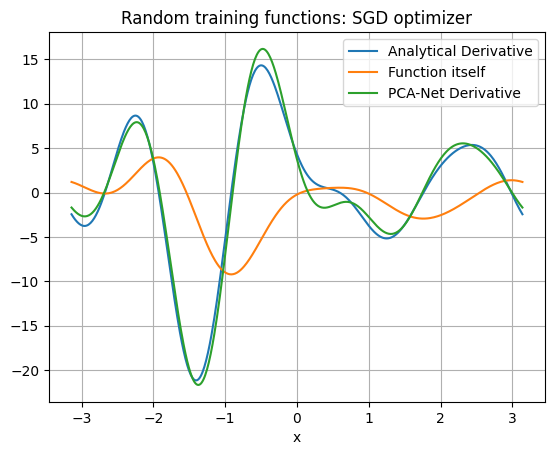

In [25]:
plt.plot(sensor_points,testder2.squeeze(),label="Analytical Derivative") #squeeze removes all dimensions from size 1
plt.plot(sensor_points,testfun2.squeeze(),label="Function itself")
plt.plot(sensor_points,test_out2.detach().numpy().squeeze(),label="PCA-Net Derivative")
#plt.plot(sensor_points,f_der.squeeze(),label="Derivative")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions: SGD optimizer")
plt.legend()


Choose different model architecture:

In [26]:
class FiveLayerSELU2(nn.Module):
    def __init__(self):
        super(FiveLayerSELU2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 100),
            nn.SELU(),
            nn.Linear(100, 200),
            nn.SELU(),
            nn.Linear(200, 100),
            nn.SELU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        return self.net(x)

In [27]:
# Modell, Loss, Optimizer
model3 = FiveLayerSELU2()
criterion = nn.MSELoss()
optimizer = optim.SGD(model3.parameters(), lr=0.0001, momentum=0.99)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_all = []
for epoch in range(10000):
    outputs = model3(f_encoded)
    loss = criterion(outputs, f_encoded_der)
    loss_all.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 5291.6621
Epoch 2, Loss: 5276.1021
Epoch 3, Loss: 5245.3555
Epoch 4, Loss: 5199.8516
Epoch 5, Loss: 5139.8960
Epoch 6, Loss: 5064.4634
Epoch 7, Loss: 4970.0127
Epoch 8, Loss: 4848.8086
Epoch 9, Loss: 4687.3760
Epoch 10, Loss: 4463.7231
Epoch 11, Loss: 4145.7114
Epoch 12, Loss: 3694.7681
Epoch 13, Loss: 3094.2827
Epoch 14, Loss: 2443.3591
Epoch 15, Loss: 2094.7439
Epoch 16, Loss: 2381.3884
Epoch 17, Loss: 2603.6868
Epoch 18, Loss: 2178.2771
Epoch 19, Loss: 1900.4736
Epoch 20, Loss: 1963.6967
Epoch 21, Loss: 2258.7510
Epoch 22, Loss: 2436.3535
Epoch 23, Loss: 2526.6233
Epoch 24, Loss: 2454.5891
Epoch 25, Loss: 2401.6997
Epoch 26, Loss: 2401.2639
Epoch 27, Loss: 2387.6409
Epoch 28, Loss: 2353.3682
Epoch 29, Loss: 2360.7361
Epoch 30, Loss: 2376.7236
Epoch 31, Loss: 2204.7656
Epoch 32, Loss: 1927.0798
Epoch 33, Loss: 1804.1830
Epoch 34, Loss: 1813.7526
Epoch 35, Loss: 1784.4906
Epoch 36, Loss: 1656.4674
Epoch 37, Loss: 1547.3818
Epoch 38, Loss: 1550.6168
Epoch 39, Loss: 1613.

Performing PCA-net on test function:

In [32]:
testfun3, testder3 = generate_exponential_fourier_functions(1,sensor_points)
test_coeffs3 = testfun3 @ principalComponents_t2
test_coeffs_der3 = model3.forward(test_coeffs3)
test_out3 = principalComponents_t_der2 @ test_coeffs_der3.T

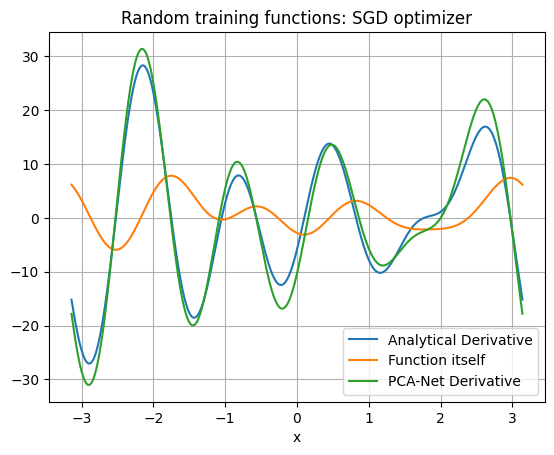

In [33]:
plt.plot(sensor_points,testder3.squeeze(),label="Analytical Derivative") #squeeze removes all dimensions from size 1
plt.plot(sensor_points,testfun3.squeeze(),label="Function itself")
plt.plot(sensor_points,test_out3.detach().numpy().squeeze(),label="PCA-Net Derivative")
plt.grid()
plt.xlabel("x")
plt.title("Random training functions: SGD optimizer")
plt.legend()